# 3.A. How we handle numerical data in the ecosystem

In many previous examples it was often the case that the returned result of a function was a `Dataset`. For example `trajectory` and `poincaresos` return a `Dataset`.

What is a `Dataset`?

In [ ]:
using DynamicalSystems, Plots
dataset = Dataset(rand(1000, 3));

A `Dataset` is how we handle numerical data in **DynamicalSystems.jl**. In essense it is a wrapper of `Vector{SVector}` (staticallly sized vectors). Besides that, `Dataset` has matrix-like indexing support:

* when accessing a `Dataset` with a single index it acts as a vector of static vectors

In [2]:
typeof( dataset[1])

StaticArrays.SArray{Tuple{3},Float64,1,3}

In [3]:
x = 0.0
for point in dataset # point is a static vector
    x += point[1] - point[2]
end
x

3.225927475509353

* when accessed with two indices a `Dataset` acts _like_ a matrix where each _row_ is one data point. Equivalently, it is accessed as the matrix it is printed like.

In [4]:
dataset[1, 2]

0.2634028404493003

In [5]:
dataset[1, 2] == dataset[1][2]

true

In [6]:
dataset[:, 1]

1000-element Array{Float64,1}:
 0.07687939576076608
 0.5610761666832733 
 0.28771478442823306
 0.14956431200922404
 0.9020415757020597 
 0.6680585584870748 
 0.8647593080825096 
 0.9832335303168547 
 0.5041623487692497 
 0.4323669617375536 
 0.05143915774870211
 0.5541462321019981 
 0.5541762404738451 
 ⋮                  
 0.5310015358355129 
 0.09644878281389135
 0.829294929161053  
 0.769801397746064  
 0.16281092727227064
 0.3615356774495313 
 0.5868736512252803 
 0.761121187921243  
 0.9749736513242317 
 0.27022464974633653
 0.15964832641345095
 0.04880215996577264

In [7]:
dataset[1:10, :]

3-dimensional Dataset{Float64} with 10 points
 0.0768794  0.263403   0.566667
 0.561076   0.880833   0.601035
 0.287715   0.178995   0.857034
 0.149564   0.0418038  0.402704
 0.902042   0.792488   0.929234
 0.668059   0.0438904  0.911421
 0.864759   0.247499   0.443819
 0.983234   0.181785   0.860978
 0.504162   0.613865   0.675738
 0.432367   0.63899    0.720897

# 3.B. Delay Coordinates Embedding
Let's say you have a "real-world system" which you measure in an experiment or so. You are assuming that the system is composed of several dynamic variables, but you can only measure one of them (or some function of the variable).

You have a severe lack of recorded information for the system. What do you do?
1. Give up on science, it is a complete waste of time.
2. Use [Takens theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem), which is indistinguishable from magic.

**DynamicalSystems.jl** suggests the latter.

From a timeseries $s$ one can *reconstruct* a state-space $\mathbf{z}$ simply by shifting $s$ in time, like
  
  $$\mathbf{z}(n) = (s(n), s(n+\tau), s(n+2\tau), \dots, s(n+\gamma\tau))$$
  
This is done with the `reconstruct(s, γ, τ)` function or the `embed(s, D, τ)` function (with the embedding dimension `D = γ + 1`).

In [8]:
s = rand(100000)
γ = 3 # how many temporal neighbors?
τ = 1 # delay time
R = reconstruct(s, γ, τ)

4-dimensional Dataset{Float64} with 99997 points
 0.632902   0.751893   0.144797   0.383501 
 0.751893   0.144797   0.383501   0.450787 
 0.144797   0.383501   0.450787   0.157848 
 0.383501   0.450787   0.157848   0.513251 
 0.450787   0.157848   0.513251   0.121381 
 0.157848   0.513251   0.121381   0.555429 
 0.513251   0.121381   0.555429   0.480742 
 0.121381   0.555429   0.480742   0.408758 
 0.555429   0.480742   0.408758   0.780158 
 0.480742   0.408758   0.780158   0.279617 
 0.408758   0.780158   0.279617   0.578298 
 0.780158   0.279617   0.578298   0.782271 
 0.279617   0.578298   0.782271   0.951776 
 ⋮                                         
 0.719755   0.0301375  0.556226   0.55039  
 0.0301375  0.556226   0.55039    0.959994 
 0.556226   0.55039    0.959994   0.923868 
 0.55039    0.959994   0.923868   0.855049 
 0.959994   0.923868   0.855049   0.191316 
 0.923868   0.855049   0.191316   0.942915 
 0.855049   0.191316   0.942915   0.205264 
 0.191316   0.942915   0.20

`reconstruct` and `embed` return a `Dataset` as well. Because of this they are very fast to compute!

## But how is this even helpful?

What we have done is more than just a fancy way to produce a higher dimensional dataset out of a univariate timeseries. For a proper choice of `τ, γ` [Takens theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem) says that the reconstructed trajectory is homeomorphic with a true, real trajectory of that dynamical system that we got `s` from.

In sort, many quantities like e.g. the Lyapunov exponents, the dimension of the attracting set, etc., are the same for the real dynamical system and the one we reconstructed here numerically. **Even though we are clueless of how many variables the system may have in reality**.

We will be confirming this concept numerically in the next notebook.


## How does a reconstruction look?
The `gissinger` system is a 3D chaotic continuous system

In [9]:
ds = Systems.gissinger(ones(3))

3-dimensional continuous dynamical system
 state:       [1.0, 1.0, 1.0]
 e.o.m.:      gissinger_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [0.119, 0.1, 0.9]

In [10]:
using DynamicalSystemsBase

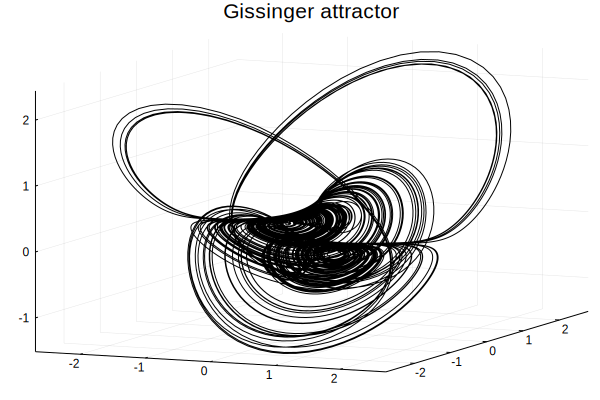

In [11]:
dt = 0.05
data = trajectory(ds, 2000.0, dt = dt, Ttr=10)

xyz = columns(data)

plot(xyz..., leg=false, title="Gissinger attractor", color=:black)

In [12]:
typeof(columns(data))

Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}

Here are some some examples of reconstructions of the `gissinger` system, using each of the variables of the system, different delay times and embedding dimension of `2` 

In [13]:
ds = Systems.gissinger(ones(3)) # 3D continuous chaotic system, also shown in orbit diagrams tutorial
dt = 0.05
data = trajectory(ds, 2000.0, dt = dt)


k = 1
subplots = []
for i in 1:3, j in 1:3
    τ =  [5, 30, 100][j]
    R = reconstruct(xyz[i], 1, τ)
    push!(subplots, plot(R[:, 1], R[:, 2], color = :black, lw = 0.8, title="var = $i, \\tau = $τ"))
    k+=1
end

subplots = reshape(subplots, 3,3)
plot(subplots..., layout=(3,3), size=(1000, 1000), legend=false)

Someone familiar with delay coordinates embadding, will see that `τ = 5` is too small while `τ = 100` is too big. `τ = 30` seems okay, but it is not possible to say if it is optimal.

# 3.C. Estimating an optimal delay time

It is important to understand that for Takens theorem to work one still has to choose "appropriately good" values for both the delay time as well as the embedding dimension!

Thankfully, **DynamicalSystems.jl** has full support for that as well!

* `estimate_delay` estimates delay time `τ` using the autocorrelation of the signal
* `estimate_dimension` returns an estimator for the amount of temporal neighbors `γ` using Cao's method

Let's focus on `estimate_delay` for now:

In [14]:
?estimate_delay

search: estimate_delay estimate_dimension estimate_period



```
estimate_delay(s, method::String [, τs = 1:2:100]; kwargs...) -> τ
```

Estimate an optimal delay to be used in [`reconstruct`](@ref) or [`embed`](@ref). The `method` can be one of the following:

  * `"ac_zero"` : first delay at which the auto-correlation function becomes <0.
  * `"ac_min"` : delay of first minimum of the auto-correlation function.
  * `"mi_min"` : delay of first minimum of mutual information of `s` with itself (shifted for various `τs`). Keywords `nbins, binwidth` are propagated into [`mutualinformation`](@ref).
  * `"exp_decay"` : [`exponential_decay_fit`](@ref) of the correlation function rounded  to an integer (uses least squares on `c(t) = exp(-t/τ)` to find `τ`).
  * `"exp_extrema"` : same as above but the exponential fit is done to the absolute value of the local extrema of the correlation function.

Both the mutual information and correlation function (`autocor`) are computed *only* for delays `τs`. This means that the `min` methods can never return the first value of `τs`!

The method `mi_min` is significantly more accurate than the others and also returns good results for most timeseries. It is however the slowest method (but still quite fast!).


---
For the `gissinger` system above, by looking at the reconstruction plots it seems that a delay time close `30` is a good value.

Let's use some methods for `estimate_delay` and see what we get.

In [15]:
s = data[:, 1]

methods = ["ac_zero", "mi_min", "exp_decay"]
for method in methods
    τ = estimate_delay(s, method, 0:1:400)
    println("For method = $(method), τ = $τ")
end

For method = ac_zero, τ = 400

┌ Warning: Did not cross 0 value, returning last `τ`.
└ @ DelayEmbeddings C:\Users\Yuxi\.julia\packages\DelayEmbeddings\IID0k\src\estimate_delay.jl:41



For method = mi_min, τ = 50
For method = exp_decay, τ = 1313


What we observe is that "zero of autocorrelation" method failed completely. Also, the "correlation exponential decay" method returned a very bad result. These methods are useful only in specific cases: the first one when the autocorrelation function is oscillatory, and the latter when the correlation decays as an exponential.

On the other side, the first minimum of the mutual information is generally helpful (but also most costly to compute).

---

Let's plot the autocorrelation function and the mutual information 

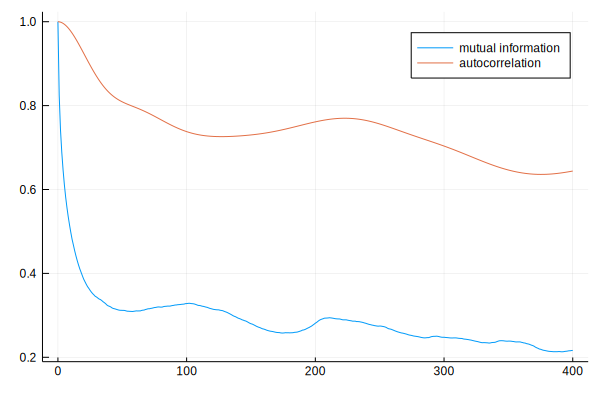

In [16]:
using StatsBase

τ = 0:400
ac = autocor(s, τ)
mi = mutualinformation(s, τ)
plot(τ, mi ./ maximum(mi), label = "mutual information")
plot!(τ, ac, label = "autocorrelation")

The autocorrelation not only never crosses zero, but also doesn't decay as an exponential. On the other side, the first minimum of the mutual information of `s` with itself has a value very close to what made sense from plotting the reconstructions.

# 3.D. Fast (self-)Mutual Information

A good method for estimating a proper delay time is the mutual information between a timeseries `s` and itself shifted in time. The function `mutualinformation` computes this quantity. Internally it uses an advanced (to-be-published) algorithm that improves existing standards and can reach high speeds. For example

In [17]:
@time mutualinformation(s, 1:100)
println("For length: ", length(s))

  0.316674 seconds (24.16 k allocations: 63.676 MiB, 7.38% gc time)
For length: 40001
